<span style="font-size:50px"><strong>ML4HC Project 1 - Task 3</strong></span>


In [95]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F



# Define paths
data_dir = "../ml4h_data/p1/"#"data"

pd.set_option('display.max_columns', None)


# Transformer Model - Q2.3

### Model and training loop

In [84]:
class Transformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, num_classes=1, max_len=700,dropout=0.1):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, model_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_head = nn.Sequential(
            nn.Linear(model_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, T, F)
        x = self.input_proj(x)                     # -> (B, T, D)
        x = x + self.positional_encoding[:, :x.size(1)]  # add position info
        x = self.transformer(x)                    # -> (B, T, D)
        x = x.mean(dim=1)                          # average pooling
        return self.cls_head(x).squeeze(-1)


In [5]:
def train_transformer(model, dataloader, val_dataloader=None, epochs=10, lr=1e-3, weight_decay=0.0, device="cuda" if torch.cuda.is_available() else "cpu", checkpoint_path="best_model.pt"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss()

    history = {"train_loss": [], "val_loss": [], "val_auroc": [], "val_auprc": []}
    best_auroc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch).squeeze()
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        history["train_loss"].append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}")

        if val_dataloader:
            auroc, auprc, val_loss = evaluate_transformer(model, val_dataloader, device)
            history["val_loss"].append(val_loss)
            history["val_auroc"].append(auroc)
            history["val_auprc"].append(auprc)
            print(f"Val AUROC: {auroc:.4f}  AUPRC: {auprc:.4f}  Val Loss: {val_loss:.4f}")

            if auroc > best_auroc:
                best_auroc = auroc
                best_state = model.state_dict()

    if best_state:
        torch.save(best_state, checkpoint_path)
        print(f"✅ Best model saved with AUROC = {best_auroc:.4f} at {checkpoint_path}")

    plot_training_curves(history)
    return history

In [6]:

def plot_training_curves(history):
    epochs_range = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    if history["val_loss"]:
        plt.plot(epochs_range, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history["val_auroc"], label="AUROC")
    plt.xlabel("Epoch"); plt.ylabel("AUROC"); plt.title("Validation AUROC")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history["val_auprc"], label="AUPRC")
    plt.xlabel("Epoch"); plt.ylabel("AUPRC"); plt.title("Validation AUPRC")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [7]:

def evaluate_transformer(model, dataloader, device):
    model.eval()
    all_probs, all_labels = [], []
    total_loss = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch).squeeze()
            loss = criterion(logits, y_batch)
            total_loss += loss.item()
            probs = torch.sigmoid(logits).cpu()
            all_probs.append(probs)
            all_labels.append(y_batch.cpu())

    probs = torch.cat(all_probs)
    labels = torch.cat(all_labels)

    auroc = roc_auc_score(labels, probs)
    auprc = average_precision_score(labels, probs)
    val_loss = total_loss / len(dataloader)

    print(f"Val AUROC: {auroc:.4f}  AUPRC: {auprc:.4f}  Val Loss: {val_loss:.4f}")
    return auroc, auprc, val_loss


In [8]:
def get_data(split="train"):
    letter_map = {"train": "a", "val": "b", "test": "c"}
    letter = letter_map[split]
    df = pd.read_parquet(f"data_{letter}_scaled.parquet")

    df = df.sort_values(by=["RecordID", "Time"])

    # Move RecordID and Time to the front
    cols = ["RecordID", "Time"] + [col for col in df.columns if col not in ["RecordID", "Time"]]
    df = df[cols]

    # Remove label from features
    features = [col for col in df.columns if col not in ["RecordID", "Time", "In-hospital_death"]]

    # Group time series per patient
    grouped = df.groupby("RecordID")[features].apply(lambda x: x.to_numpy()).tolist()
    assert all(x.shape == (49, 40) for x in grouped), "Not all patients have shape (49, 41)"

    # Convert to tensor
    X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in grouped])  # (N, 49, 41)

    # Extract labels
    y = torch.tensor(df.groupby("RecordID")["In-hospital_death"].first().values, dtype=torch.float32)

    dataset = TensorDataset(X, y) 
    return dataset


### Testing

In [9]:
train_dataset = get_data("train")
val_dataset = get_data("val")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)



Epoch 1/5 - Train Loss: 0.4094
Val AUROC: 0.5962  AUPRC: 0.1827  Val Loss: 0.4124
Val AUROC: 0.5962  AUPRC: 0.1827  Val Loss: 0.4124
Epoch 2/5 - Train Loss: 0.4046
Val AUROC: 0.7414  AUPRC: 0.3315  Val Loss: 0.4056
Val AUROC: 0.7414  AUPRC: 0.3315  Val Loss: 0.4056
Epoch 3/5 - Train Loss: 0.3672
Val AUROC: 0.7843  AUPRC: 0.4031  Val Loss: 0.3538
Val AUROC: 0.7843  AUPRC: 0.4031  Val Loss: 0.3538
Epoch 4/5 - Train Loss: 0.3446
Val AUROC: 0.7629  AUPRC: 0.4186  Val Loss: 0.3497
Val AUROC: 0.7629  AUPRC: 0.4186  Val Loss: 0.3497
Epoch 5/5 - Train Loss: 0.3503
Val AUROC: 0.7892  AUPRC: 0.3823  Val Loss: 0.3418
Val AUROC: 0.7892  AUPRC: 0.3823  Val Loss: 0.3418
✅ Best model saved with AUROC = 0.7892 at best_model.pt


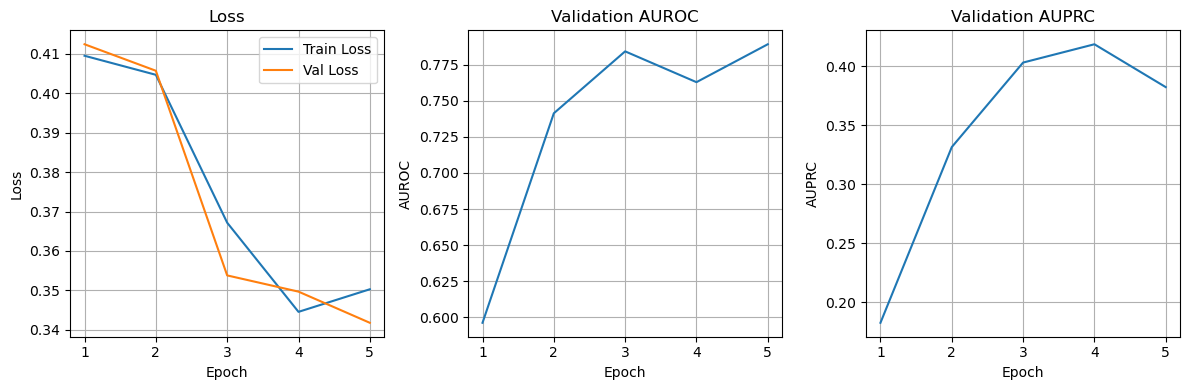

{'train_loss': [0.4094467160701752,
  0.40462010848522184,
  0.36716575968265536,
  0.34458487820625305,
  0.3503050824403763],
 'val_loss': [0.4123578779697418,
  0.40564864790439603,
  0.3538136981725693,
  0.3497051717042923,
  0.3418138462305069],
 'val_auroc': [np.float64(0.5962248945303523),
  np.float64(0.7413639031156637),
  np.float64(0.7842617329853245),
  np.float64(0.7629238792310976),
  np.float64(0.7891830513969598)],
 'val_auprc': [np.float64(0.18271350756548826),
  np.float64(0.33153975312727424),
  np.float64(0.403123651585671),
  np.float64(0.41862391250915715),
  np.float64(0.38232661613787056)]}

In [10]:
model = Transformer(input_dim=40, model_dim=64, num_layers=3, dropout=0.1)


train_transformer(model, train_loader, val_dataloader=val_loader, epochs=5, lr=1e-3)

## Q2.3b: Tokenizing Time-Series Data and Transformers 

In [82]:
def get_data_set_function(split="train"):
    letter_map = {"train": "a", "val": "b", "test": "c"}
    letter = letter_map[split]
    df = pd.read_parquet(f"data_{letter}_scaled_nonImputed.parquet")

    df["Time"] = df["Time"] / df["Time"].max()
    df = df.melt(id_vars=["RecordID", "Time"], var_name="Variable", value_name="Value")
    df = df[["RecordID", "Time", "Variable", "Value"]].reset_index(drop=True)

    # Drop ICUType
    df = df[df["Variable"] != "ICUType"]

    # For Gender, Age, Height — keep only row with smallest time per RecordID
    mask = df["Variable"].isin(["Gender", "Age", "Height", "In-hospital_death"])
    df = df[~mask | df.groupby(["RecordID", "Variable"])["Time"].transform("min").eq(df["Time"])]
    df = df.sort_values(by=["RecordID", "Time"]).reset_index(drop=True)
    df = df.dropna(subset=["Value"]).reset_index(drop=True)

    # Create target dataframe y with one row per RecordID
    y = df[df["Variable"] == "In-hospital_death"][["RecordID", "Value"]].copy()
    y = y.rename(columns={"Value": "In-hospital_death"}).set_index("RecordID")

    # Remove In-hospital_death rows from df
    df = df[df["Variable"] != "In-hospital_death"].reset_index(drop=True)
    #df.head(10)

    df = pd.get_dummies(df, columns=["Variable"],dtype=int)
    #df.head(3)

    trans_df = df.T
    column_groups= trans_df.columns.to_series().groupby(trans_df.iloc[0]).apply(list)
    trans_df = trans_df.iloc[1:]  # drop first row

    #pd.DataFrame(trans_df).iloc[:10, :20]

    # group columns by RecordID using the earlier group mapping
    patient_tensors = [
        torch.tensor(trans_df[cols].to_numpy(dtype="float32").T)  # shape: (T, F) per patient
        for cols in column_groups.values
    ]

    X = pad_sequence(patient_tensors, batch_first=True)  # shape: (N, max_T, F)
    print(X.shape[1])

    # convert labels from the y df created earlier
    y_tensor = torch.tensor(y.loc[column_groups.index, "In-hospital_death"].values, dtype=torch.float32)

    assert X.shape[0] == y_tensor.shape[0], "Mismatch between input and label sizes"
    dataset = TensorDataset(X, y_tensor)
    return dataset


678
690
Epoch 1/5 - Train Loss: 0.4084
Val AUROC: 0.5503  AUPRC: 0.1638  Val Loss: 0.4116
Val AUROC: 0.5503  AUPRC: 0.1638  Val Loss: 0.4116
Epoch 2/5 - Train Loss: 0.4038
Val AUROC: 0.5068  AUPRC: 0.1461  Val Loss: 0.4113
Val AUROC: 0.5068  AUPRC: 0.1461  Val Loss: 0.4113
Epoch 3/5 - Train Loss: 0.4030
Val AUROC: 0.5245  AUPRC: 0.1573  Val Loss: 0.4095
Val AUROC: 0.5245  AUPRC: 0.1573  Val Loss: 0.4095
Epoch 4/5 - Train Loss: 0.4026
Val AUROC: 0.5840  AUPRC: 0.2094  Val Loss: 0.4206
Val AUROC: 0.5840  AUPRC: 0.2094  Val Loss: 0.4206
Epoch 5/5 - Train Loss: 0.4056
Val AUROC: 0.5805  AUPRC: 0.2043  Val Loss: 0.4091
Val AUROC: 0.5805  AUPRC: 0.2043  Val Loss: 0.4091
✅ Best model saved with AUROC = 0.5840 at best_model.pt


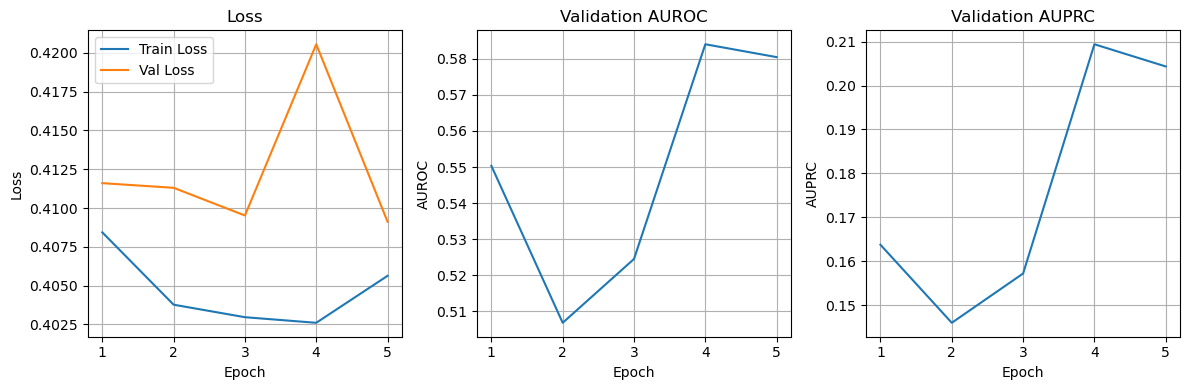

{'train_loss': [0.4084338986873627,
  0.4037736687660217,
  0.4029674825668335,
  0.4026074243783951,
  0.40563484573364256],
 'val_loss': [0.4116030453443527,
  0.41130348515510556,
  0.4095201174020767,
  0.4205510402917862,
  0.4091173303127289],
 'val_auroc': [np.float64(0.5503402114317607),
  np.float64(0.5068185922059161),
  np.float64(0.5245160502642897),
  np.float64(0.58404740799107),
  np.float64(0.5804806255950621)],
 'val_auprc': [np.float64(0.1637948021532585),
  np.float64(0.14605683472866043),
  np.float64(0.15726065818548696),
  np.float64(0.20937582279853031),
  np.float64(0.20433082718415296)]}

In [85]:
train_dataset_set_function = get_data_set_function("train")
val_dataset_set_function = get_data_set_function("val")

train_loader_set_function = DataLoader(train_dataset_set_function, batch_size=32, shuffle=True)
val_loader_set_function = DataLoader(val_dataset_set_function, batch_size=32)

model_set_function = Transformer(input_dim=41, model_dim=64, num_layers=3, dropout=0.1)

train_transformer(model_set_function, train_loader_set_function, val_dataloader=val_loader_set_function, epochs=5, lr=1e-3)

#  Pretraining and linear probes - Q3.1

## Model and training functions for pretraining task

In [111]:
class CPCTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, max_len=690, dropout=0.1, pred_steps=5):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)
        #self.positional_encoding = nn.Parameter(torch.randn(1, max_len, model_dim))

        # Encoder to get latent representations z_t
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Autoregressive model g_ar (Transformer to summarize z_<=t into c_t)
        ar_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.g_ar = nn.TransformerEncoder(ar_layer, num_layers=1)

        self.pred_steps = pred_steps
        self.prediction_heads = nn.ModuleList([
            nn.Linear(model_dim, model_dim) for _ in range(pred_steps)
        ])

    def forward(self, x):
        # x: (B, T, F)
        x = self.input_proj(x)                                 # (B, T, D)
        #x = x + self.positional_encoding[:, :x.size(1)]        # Add positional encoding
        z = self.encoder(x)                                    # (B, T, D)
        c = self.g_ar(z)                                       # (B, T, D)
        c_t = c[:, -1, :]                                      # Use only final time step context
        return z, c_t  # Return full latents and final context vector


In [103]:
def cpc_loss(z, c_t, prediction_heads, pred_steps=5):
    """
    z: (B, T, D) - latent sequence
    c_t: (B, D) - final context from g_ar
    prediction_heads: list of linear layers
    """
    B, T, D = z.shape
    device = z.device
    loss = 0.0
    n_loss_terms = 0

    for k in range(1, pred_steps + 1):
        if T <= k:
            continue  # skip if not enough future steps

        z_target = z[:, -1 + k, :]  # true future latent
        Wk = prediction_heads[k - 1]
        z_pred = Wk(c_t)
        pos_score = torch.sum(z_pred * z_target, dim=-1)

        # Negative sampling
        neg_indices = torch.randperm(B)
        z_neg = z[neg_indices, -1 + k, :]
        neg_score = torch.sum(z_pred * z_neg, dim=-1)

        logits = torch.stack([pos_score, neg_score], dim=1)
        labels = torch.zeros(B, dtype=torch.long, device=device)

        loss += F.cross_entropy(logits, labels)
        n_loss_terms += 1

    return loss / n_loss_terms if n_loss_terms > 0 else torch.tensor(0.0, device=device)


In [104]:
def train_cpc(model, dataloader, epochs=10, lr=1e-3, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"loss": []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x_batch, _ in dataloader:  # ignore labels
            x_batch = x_batch.to(device)

            z, c_t = model(x_batch)
            loss = cpc_loss(z, c_t, model.prediction_heads, model.pred_steps)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        history["loss"].append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - CPC Loss: {avg_loss:.4f}")

    # extract embeddings (context vector c_t) for all data
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for x_batch, _ in dataloader:
            x_batch = x_batch.to(device)
            _, c_t = model(x_batch)  # extract c_t directly
            all_embeddings.append(c_t)

    embeddings = torch.cat(all_embeddings, dim=0)  # (N, D)
    return history, embeddings


## Model evaluation and classification task

In [ ]:
train_dataset_pretraining = get_data_set_function("train")
val_dataset_pretraining   = get_data_set_function("val")
test_dataset_pretraining  = get_data_set_function("test")

batch_size=128
train_loader_pretraining = DataLoader(train_dataset_pretraining, batch_size=batch_size, shuffle=True)
val_loader_pretraining   = DataLoader(val_dataset_pretraining, batch_size=batch_size)
test_loader_pretraining  = DataLoader(test_dataset_pretraining, batch_size=batch_size)

model_pretrained = CPCTransformer(input_dim=41, model_dim=16, num_layers=3, dropout=0.1, pred_steps=1)

history, embeddings= train_cpc(model_pretrained, train_loader_pretraining, epochs=5, lr=1e-3)
#train_cpc(model__pretrained, train_loader_pretraining, val_dataloader=val_loader_pretraining, epochs=5, lr=1e-3)

678
690
630


In [ ]:
def extract_embeddings(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    all_embeddings, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            _, c_t = model(x_batch)
            all_embeddings.append(c_t.cpu())
            all_labels.append(y_batch.cpu())

    X = torch.cat(all_embeddings).numpy()
    y = torch.cat(all_labels).numpy()
    return X, y


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

# Freeze weights
for param in model_pretrained.parameters():
    param.requires_grad = False

# Extract embeddings
X_train, y_train = extract_embeddings(model_pretrained, train_loader_pretraining)
X_test, y_test = extract_embeddings(model_pretrained, test_loader_pretraining)

# Train linear probe
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)
auprc = average_precision_score(y_test, y_pred)

print(f"Linear Probe AUROC: {auroc:.4f}")
print(f"Linear Probe AUPRC: {auprc:.4f}")

630
Linear Probe AUROC: 0.5635
Linear Probe AUPRC: 0.2109


#  Simulate label scarcity - Q3.2

#  Visualising learned representations - Q3.3
